In [6]:
# Load dependencies
%matplotlib inline
import matplotlib
import json
import time
import requests
import os.path
import pandas as pd
import numpy as np
from sklearn import decomposition
from scipy.stats import zscore, ttest_ind
import matplotlib.pyplot as plt
from IPython.display import display, HTML, Image
from clustergrammer_widget import *
from copy import deepcopy
pd.options.mode.chained_assignment = None

marrow (30854, 53)
(14763, 6) ... after filtering
spleen (30853, 53)
(14907, 6) ... after filtering


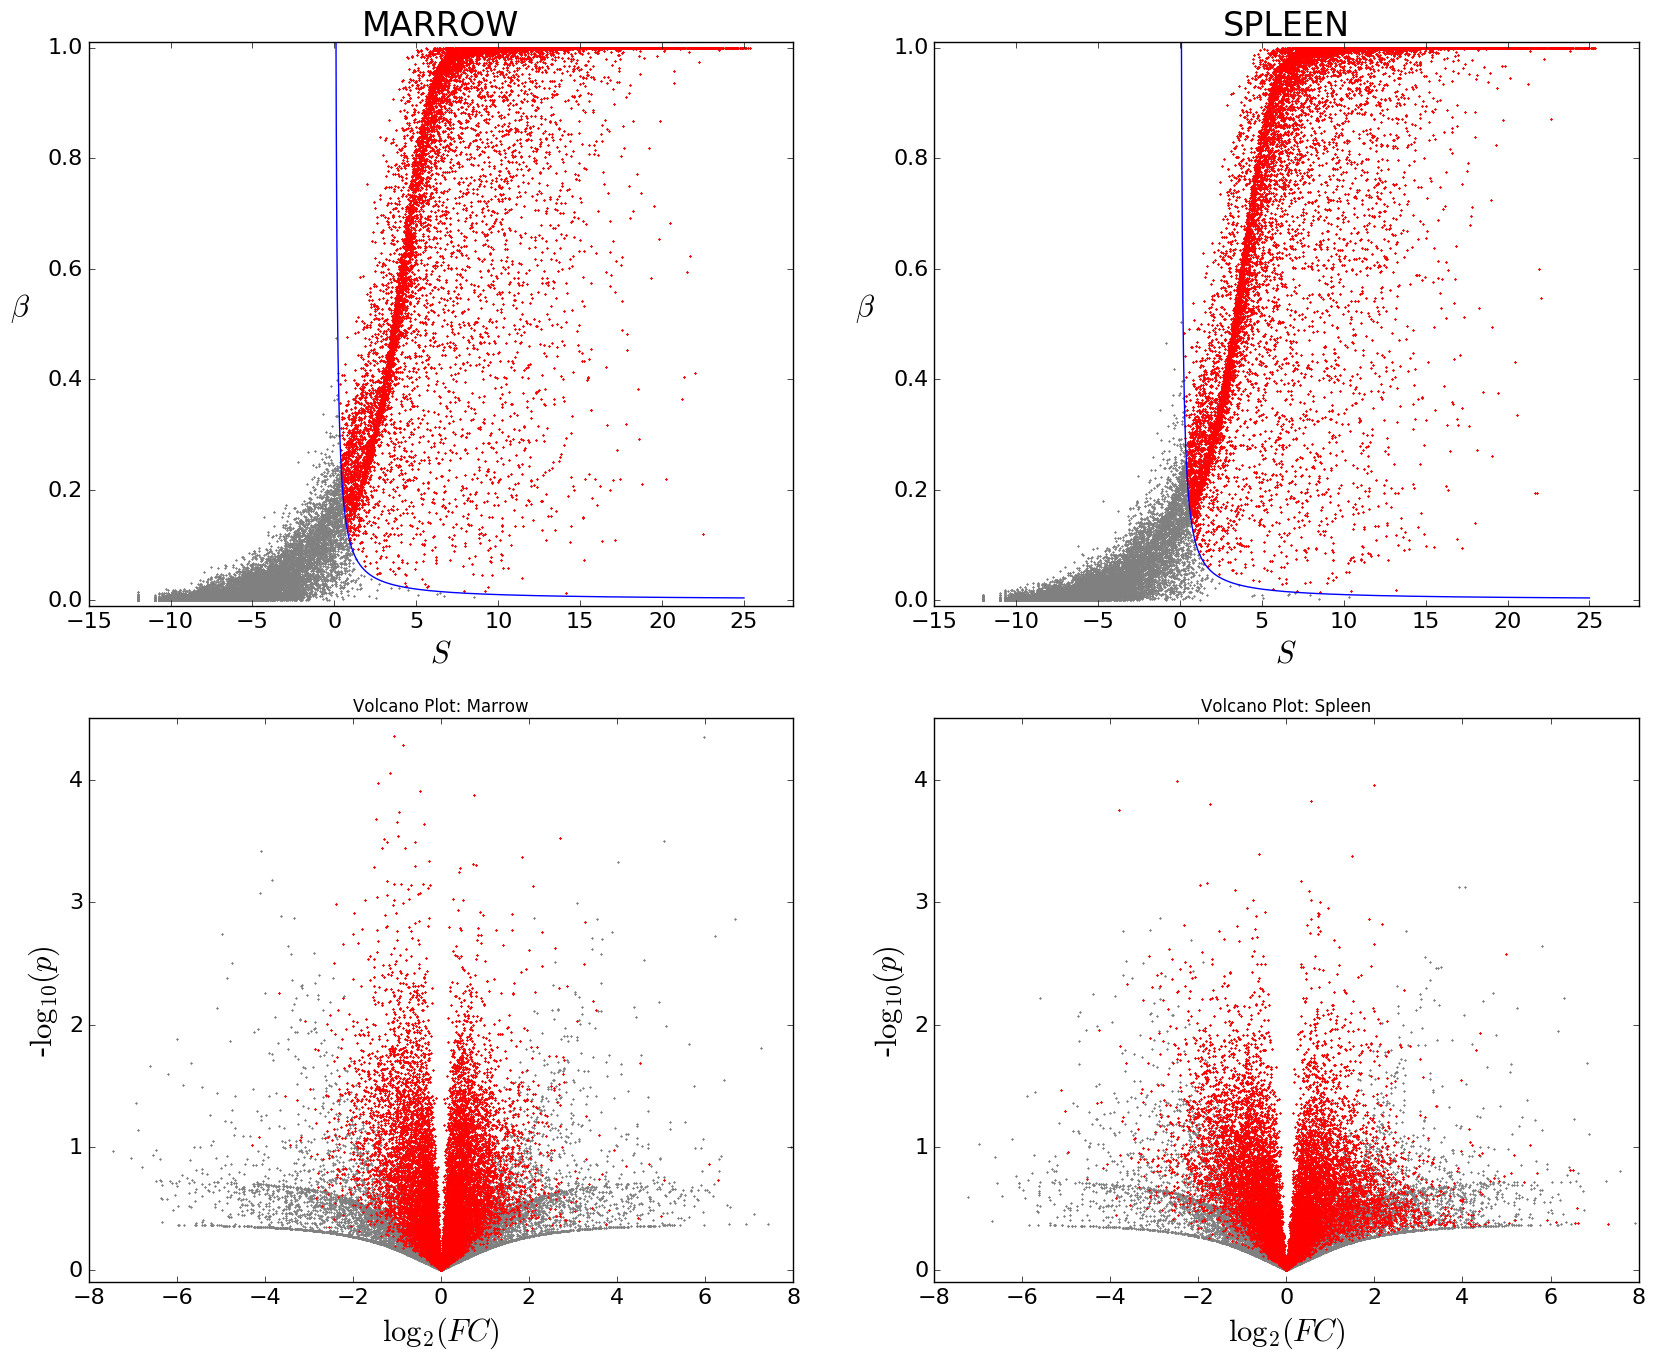

In [7]:
p_cut = 0.9 # require gt p probability of background difference
s_cut = 3.0 # require maximum of each row is greeater than s

# Load data
dat = {}
dat['marrow'] = pd.read_table('GATA1_marrow_profile.txt',sep='\t',index_col=0)
dat['spleen'] = pd.read_table('GATA1_spleen_profile.txt',sep='\t',index_col=0)

cd_cols = ['cd1','cd2','cd3']
gat_cols = ['gat1','gat2','gat3']

def exp_f1(x): 
    return 1.0/(10*x)

def exp_f2(x):
    return 0.7 - 0.2*np.log10(np.abs(x) - 0.5)

fig = plt.figure(figsize=(20, 16), dpi=100)

for i in range(len(dat.keys())):
    tissue = dat.keys()[i]
    df = dat[tissue]
    
    print tissue, df.shape
    
    pvals = df[['cd1.Detection Pval','cd2.Detection Pval','cd3.Detection Pval',
                'gat1.Detection Pval','gat2.Detection Pval','gat3.Detection Pval']]
    signal = df[['cd1.AVG_Signal','cd2.AVG_Signal','cd3.AVG_Signal',
                 'gat1.AVG_Signal','gat2.AVG_Signal','gat3.AVG_Signal']]
    
    signal[signal < 0.0] = 0.0
        
    signal.columns = [ x.replace('.AVG_Signal','') for x in signal.columns.values ]
    pvals.columns = [ x.replace('.AVG_Signal','') for x in pvals.columns.values ]

    # Multiple hypothesis correction
    multi_p = 1.0 - pvals.apply( lambda p: np.prod(1.0-p), axis=1)
        
    control = signal[cd_cols]
    treated = signal[gat_cols]
        
    fc = np.mean(treated, axis=1)/np.mean(control, axis=1)
    tstat, t_pvals = ttest_ind(control, treated, axis=1, equal_var=False)
    t_pvals = pd.Series(t_pvals, index=fc.index)

    x1 = np.sum(np.log10(0.01 + signal),axis=1)
    y1 = 1.0 - multi_p

    x2 = np.log2(fc)
    y2 = -np.log10(t_pvals)

    keep = (y1 > exp_f1(x1)) & (x1 > 0.0)

    fig.add_subplot(2,2,i+1)   
    x = np.linspace(0, 25, 10000)
    y = exp_f1(x)
    plt.plot(x, y)
    plt.scatter(x1, y1, s=1, c='gray', marker='x')
    plt.scatter(x1[keep], y1[keep], s=1, c='red', marker='x')
    plt.xlabel(r'$S$',fontsize=22)
    plt.ylabel(r'$\beta$',fontsize=22,rotation=0,labelpad=20)
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)
    plt.title(tissue.upper(),fontsize=24)
    plt.axis([-15, 28, -0.01, 1.01])

    fig.add_subplot(2,2,i+3)
    plt.scatter(x2, y2, s=1, c='gray', marker='x')
    plt.scatter(x2[keep], y2[keep],s=1,c='red',marker='x')
    plt.xlabel(r'$\log_2(FC)$', fontsize=22)
    plt.ylabel(r'-$\log_{10}(p)$', fontsize=22)
    plt.title('Volcano Plot: '+tissue.title())
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)
    plt.axis([-8, 8, -0.1, 4.5])
    
    signal.columns = [ tissue+'.'+s for s in signal.columns.values ]
    pvals.columns = [ tissue+'.'+s for s in pvals.columns.values ]

    dat[tissue] = signal[keep]
    print dat[tissue].shape,'... after filtering'


#### Figure 1.  Filtering gene expression.
Gene expression less than zero is mapped to zero. The following cutoff is used to select the genes with a reasonable signal-to-noise ratio:
##### $$\begin{align} \beta\cdot\log_{10}(S) > 0.1 \end{align}$$
where _S_ is the sum of gene expresion across samples. That is, we require that product of the detection power and the log sum gene expression be greater than 0.1. Thus when $\beta = 1.0$, we include a gene with sum expression 0.1 or more, and for $\beta = 0.1$, we require that the sum of gene expression be greater than 10. Roughly half of the genes profiled in the microarray are filtered out in this way.

In [10]:
# Concatenate expression matrices using union of rows (genes)
df = pd.concat(dat.values(),axis=1)
print len(df[df.isnull().any(axis=1)]) ,"null genes removed"
df = df[~df.isnull().any(axis=1)]

# Figure specs for PCA
samples = df.columns.values
colors = np.array([ '#C1292E' if 'spleen' in x else '#235789' for x in samples ])
shapes = np.array([ u'o' if 'cd' in x else u'^' for x in samples ])
labels = np.array([ x.split('.')[1][-1] for x in samples ])

# Choose 2000 genes with greatest variance and zscore them
print df.shape
# mat = df.transpose().as_matrix()
mat = np.log2(df.transpose().as_matrix() + 1.0)
print mat.shape
featvars = list(np.var(mat,axis=0))
select = np.argsort(featvars)[-2000:]
# mat = mat[:,select]
mat = zscore(mat[:,select])

# View high-variance genes with clustergrammer
net = deepcopy(Network())
tmp = {"mat":pd.DataFrame(np.transpose(mat), index=df.index[select], columns=df.columns)}
net.df_to_dat(tmp)
net.make_clust()
clustergrammer_notebook(network = net.export_net_json())

2988 null genes removed
(13341, 12)
(12, 13341)


(12, 2000)


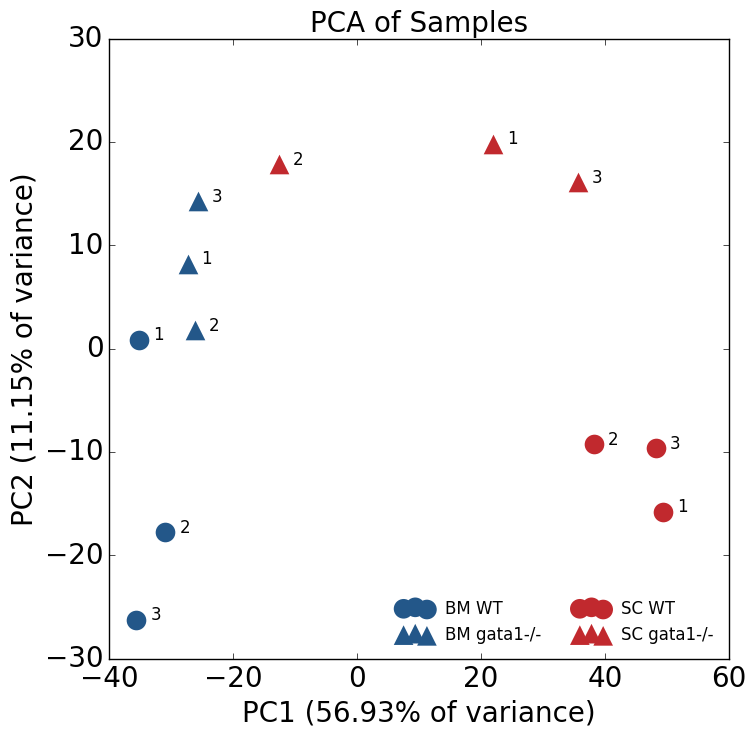

In [11]:
# Compute PCA Coordinates and Variance
print mat.shape
pca = decomposition.PCA(n_components=None)
pca.fit(mat)
variance_explained = pca.explained_variance_ratio_[0:2] * 100

pca_coords = pca.transform(mat)[:, 0:2]
pca1, pca2 = zip(*pca_coords)

# Plot Results
fig = plt.figure(figsize=(8, 8), dpi=80)

legs = []
for i in range(0,12,3):
    _s, _c  = shapes[i], colors[i]
    _x, _y = np.array(pca1)[range(i,i+3)], np.array(pca2)[range(i,i+3)]
    ax = plt.scatter(_x, _y, s=200, marker=_s, c=_c, lw = 0)
    legs.append(ax)

axlabels = ['PC%s (%.2f' % (i,pct) + '%' + ' of variance)'
          for i,pct in enumerate(variance_explained, start=1)]

for label, x, y in zip(labels,pca1,pca2):
    plt.annotate(label,xy=(x,y),xytext = (10, 0), textcoords = 'offset points', fontsize=12)
    
plt.xlabel(axlabels[0],fontsize=20)
plt.ylabel(axlabels[1],fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("PCA of Samples",fontsize=20)

plt.legend(legs,('BM WT','BM gata1-/-','SC WT','SC gata1-/-'),
           ncol=2, loc='lower right',frameon=False)
plt.show()

#### Figure 2.  PCA of Gene Expression.
Using the union of expression data from spleen cells (SC) and bone marrow (BM), principal component analysis is performed on the z-scored log2 expression values of the 2000 most variable genes.

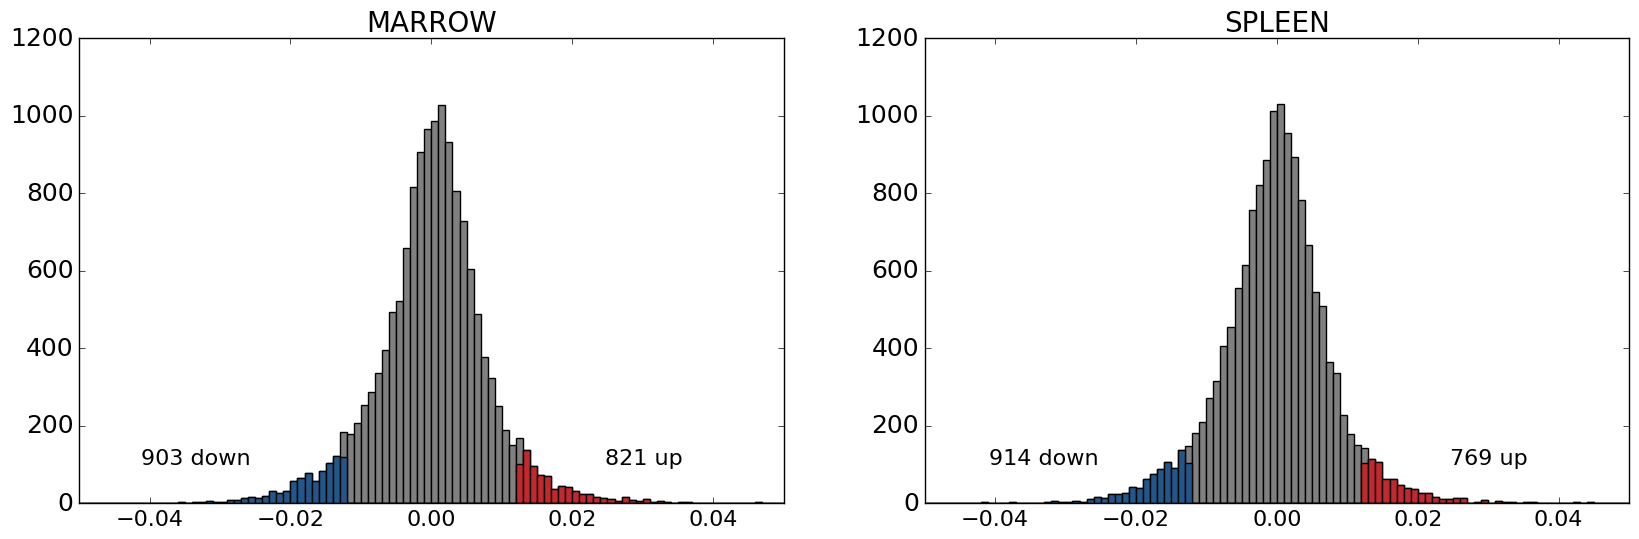

In [34]:
from chdir import chdir

cdsigs = {}
degs = {}

fig = plt.figure(figsize=(20, 6), dpi=100)

for i in range(len(dat.keys())):
    tissue = dat.keys()[i]
    degs[tissue] = {}
    df = dat[tissue]
    df = np.log2(df + 1.0)
    genelist = df.index.values
    
    ctrData = df[[ tissue+'.'+x for x in ['cd1','cd2','cd3']]].values
    expData = df[[ tissue+'.'+x for x in ['gat1','gat2','gat3']]].values

    # Get the charactersitic direction signature
    [cdGenes,cdVector] = chdir(ctrData,expData,genelist)

    s = pd.Series(cdVector, index=cdGenes, name=tissue).sort_index().dropna()
    s = s[[ gene for gene in genelist if '$' not in gene ]]
    cdsigs[tissue] = s
    dg = s[np.abs(s) > 1.5*np.std(s)].sort_values(ascending=False)
    degs[tissue]['dn'] = dg[dg<0.0]
    degs[tissue]['up'] = dg[dg>0.0]
    s.to_csv('GATA1_'+tissue+'_cdVector.txt',sep='\t')
    degs[tissue]['dn'].to_csv('GATA1_'+tissue+'_deg_dn.txt',sep='\t')
    degs[tissue]['up'].to_csv('GATA1_'+tissue+'_deg_up.txt',sep='\t')
    
    fig.add_subplot(1,2,i+1)
    plt.hist(s,np.arange(-0.06,0.06,0.001),facecolor='gray')
    plt.hist(dg[dg>0.0],np.arange(-0.06,0.06,0.001),facecolor='#C1292E')
    plt.hist(dg[dg<0.0],np.arange(-0.06,0.06,0.001),facecolor='#235789')
    plt.annotate(str(len(dg[dg<0.0]))+' down',xy=(-5*np.std(s),100), fontsize=16)
    plt.annotate(str(len(dg[dg>0.0]))+' up',xy=(3*np.std(s),100), fontsize=16)
    plt.xticks(fontsize=16); plt.yticks(fontsize=18)
    plt.title(tissue.upper(),fontsize=20)
    plt.axis([-0.05,0.05,0,1200])


#### Figure 3. Histogram of characteristic direction values.
A cutoff $\mathopen|S\mathclose| > 1.5\sigma$ is used to identify the differentially expressed genes.

In [14]:
#  Select DEGs and save them to file
common_genes = np.unique(cdsigs['spleen'].index.tolist() + cdsigs['marrow'].index.tolist())

cd_diff = cdsigs['spleen'][common_genes] - cdsigs['marrow'][common_genes]
cd_diff = cd_diff.dropna()
cd_diff = cd_diff/np.linalg.norm(cd_diff)

cd_diff.to_csv('GATA1_SC-BM_cdVector.txt',sep='\t')
deg_diff = cd_diff[np.abs(cd_diff) > 2*np.std(cd_diff)]

deg_diff[deg_diff>0.0].to_csv('GATA1_SC-BM_degs_up-spleen.txt',sep='\t')
deg_diff[deg_diff<0.0].to_csv('GATA1_SC-BM_degs_dn-marrow.txt',sep='\t')
deg_diff.to_csv('GATA1_SC-BM_degs.txt',sep='\t')

### Enrichment Analysis

Enrichment analysis was accomplished via the Enrichr API. The most up- and down-regulated genes were submitted and enrichment results were retrieved for the following enrichment libraries:

In [35]:
# Libraries to use:
libraries = ['MGI_Mammalian_Phenotype_Level_4','WikiPathways_2016','GO_Biological_Process_2016',
             'ChEA_2016','PPI_Hub_Proteins','ENCODE_TF_ChIP-seq_2015','KEGG_2016']

# Use this function to call the Enrichr API:
ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr/enrich'
def fetch_enrichr_results(genes, description=''):
    """Returns a dict which maps Enrichr libraries to enrichment results."""
    session = requests.session()
    payload = {'list': (None, genes), 'description': (None, description)}
    session.post(ENRICHR_URL, files=payload)
    results = {}
    for library in libraries:
        get_url = ENRICHR_URL + '?backgroundType=%s' % library
        response = session.get(get_url)
        if response.ok:
            results[library] = json.loads(response.text)[library]
        else: print "Error"
    return results

def enrichr2dataframe(results, name, score):
    print "Aggregating",len(results),"results"
    termsUp = {}
    termsDn = {}
    value = {'cs':4, 'p-value':2, 'z-score':3}
    index = [ x[1] for x in results ]
    values = [ x[value[score]] for x in results ]
    return pd.Series(values, index=index, name=name)

In [36]:
# Perform enrichment
enriched = {}
for tissue in dat.keys():
    enriched[tissue] = {}
    enriched[tissue]['up'] = fetch_enrichr_results('\n'.join(degs[tissue]['up'].index),tissue+' GATA1-/-')
    enriched[tissue]['dn'] = fetch_enrichr_results('\n'.join(degs[tissue]['dn'].index),tissue+' GATA1-/-')

Error
Error
Error
Error


In [37]:
# Visualize enrichment results
view_library = 'ChEA_2015'
view_score = 'z-score'

series = []
for tissue in ['marrow','spleen']:
    for dirn in ['up','dn']:
        name = tissue+'_'+dirn
        s = enrichr2dataframe(enriched[tissue][dirn][view_library], name, view_score)
        series.append(s)

df = -1.0*pd.concat(series,axis=1).fillna(0.0)
df = df[ np.max(df,axis=1) > 0.5 ]
featvars = list(np.var(df.values,axis=1))
select = np.argsort(featvars)[-100:]
df = df.iloc[select,:]

net = deepcopy(Network())
tmp = {"mat":df}
net.df_to_dat(tmp)
net.make_clust()
clustergrammer_notebook(network = net.export_net_json())

KeyError: 'ChEA_2015'

#### Figure 4. Clustergrammer of Enrichment Terms from Differentially expressed genes
The heatmap contains enrichment z-scores according to the expected rank of the term from random sets.

Links to all enrichment results are below:


|  | Marrow | Spleen         
| :- |-------------: | :-:
|Up| [821 genes](http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=14djc) | [769 genes](http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=14djf)
|Down| [903 genes](http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=14djg) |[913 genes](http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=14dj9)

### L1000CDS2 Analysis

We submitted the up- and down-regulated gene lists to L1000CDS2. This tool searches through the LINCS L1000 data for small-molecule gene signatures that may reverse or mimic your input signature, allowing us to compare the GATA1-knockout characteristic direction (CD) differential expression signature with the CD signatures of nearly 4,000 small-molecules. This is done by computing the signatures with the greatest (reverse) or least (mimic) cosine distance between the CD signature vectors. A full description of the method can be found on the [_help page_](http://amp.pharm.mssm.edu/L1000CDS2/help/), and you can browse the full results on the site:

|  | Marrow | Spleen         
| :- | :-: | :-:
|Mimic| [link](http://amp.pharm.mssm.edu/L1000CDS2/#/result/58911e70e467bea600f85a76) | [link](http://amp.pharm.mssm.edu/L1000CDS2/#/result/58911f67e467bea600f85a7c)
|Reverse| [link](http://amp.pharm.mssm.edu/L1000CDS2/#/result/58911f0ae467bea600f85a78) |[link](http://amp.pharm.mssm.edu/L1000CDS2/#/result/58911f4ce467bea600f85a7a)

In [33]:
# Get L1000CDS2 Results and make tables
for tissue in dat.keys():
    for dirn in ['mimic','reverse']:
        df = pd.read_table('L100CDS2_'+tissue+'_'+dirn+'.txt', index_col=0)
        print "Small Molecules that",dirn.upper(),"the GATA1-KO",tissue.title(),"Signature:"
        cols = df.columns.values.tolist()
        cols.remove('Perturbation PubChem URL')
        cols.append('Perturbation PubChem URL')
        del df.index.name
        df = df.ix[:,cols]
        display(df.drop(['Perturbation LIFE URL','Signature URL','Perturbation DrugBank URL'],axis=1).head(10))

Small Molecules that MIMIC the GATA1-KO Marrow Signature:


,score,Perturbation,Cell-line,Dose,Time,Perturbation PubChem URL
1,0.0446,BRD-A36630025,MCF7,0.35um,24.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...
2,0.0413,QUINACRINE HYDROCHLORIDE,A375,10.0um,24.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...
3,0.0397,BMS-754807,A375,10.0um,24.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...
4,0.0380,PP-110,A375,22.2um,24.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...
5,0.0380,4-Demethoxydaunorubicin hydrochloride (65),MCF7,0.08um,24.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...
6,0.0380,BJM-ctd2-9,MCF7,10.0um,24.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...
7,0.0380,BRD-K98490050,MCF7,10.0um,24.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...
8,0.0347,BRD-K04853698,HCC515,10.0um,24.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...
9,0.0331,NICLOSAMIDE,HCC515,10.0um,24.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...
10,0.0331,IMD 0354,HCC515,10.0um,24.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...


Small Molecules that REVERSE the GATA1-KO Marrow Signature:


,score,Perturbation,Cell-line,Dose,Time,Perturbation PubChem URL
1,0.0281,radicicol,HME1,3.33um,24h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...
2,0.0248,trichostatin A,HA1E,10.0um,6.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...
3,0.0248,PD-184352,HEPG2,3.33um,24h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...
4,0.0248,geldanamycin,HS578T,1.11um,24h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...
5,0.0231,geldanamycin,MCF7,10.0um,6.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...
6,0.0215,ISOLIQUIRITIGENIN,HA1E,10.0um,24.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...
7,0.0215,BRD-K41859756,HA1E,10.0um,24.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...
8,0.0215,TG101348,HA1E,11.1um,6.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...
9,0.0215,BRD-K96799727,PC3,10.0um,6.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...
10,0.0215,Arachidonyl trifluoro-methyl ketone,VCAP,80.0um,24.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...


Small Molecules that MIMIC the GATA1-KO Spleen Signature:


,score,Perturbation,Cell-line,Dose,Time,Perturbation PubChem URL
1,0.0449,alvocidib,HME1,3.33um,3h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...
2,0.0430,alvocidib,HME1,1.11um,3h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...
3,0.0411,ER 27319 maleate,HA1E,10.0um,6.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...
4,0.0411,CGP-60474,HME1,0.12um,3h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...
5,0.0393,daunorubicin,HA1E,10.0um,6.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...
6,0.0393,656402-250MG,A375,10.0um,6.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...
7,0.0393,alvocidib,MCF10A,3.33um,3h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...
8,0.0374,linifanib,HME1,10um,3h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...
9,0.0336,ER 27319 maleate,PC3,10.0um,6.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...
10,0.0336,BMS-387032,HME1,1.11um,3h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...


Small Molecules that REVERSE the GATA1-KO Spleen Signature:


,score,Perturbation,Cell-line,Dose,Time,Perturbation PubChem URL
1,0.0748,Narciclasine,A549,10.0um,6.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...
2,0.0729,Narciclasine,HA1E,10.0um,6.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...
3,0.0710,Emetine Dihydrochloride Hydrate (74),MCF7,0.63um,6.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...
4,0.0617,BRD-K04853698,HT29,10.0um,6.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...
5,0.0598,Homoharringtonine,HA1E,10.0um,24.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...
6,0.0598,BRD-K76674262,ASC,10.0um,24.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...
7,0.0598,QL-XII-47,HS578T,10um,24h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...
8,0.0579,phorbol-12-myristate-13-acetate (PMA),MCF7,10.0um,6.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...
9,0.0561,Homoharringtonine,PC3,10.0um,6.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...
10,0.0561,EMETINE HYDROCHLORIDE,A549,10.0um,6.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summar...
